# Simulation of Morphologically-detailed models of Basket Cell

In [1]:
from cell_template import *

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

## FI-curve

In [6]:
def run_sim(cell,
            duration = 400, # ms
            dt=0.025):
    
    ic = h.IClamp(cell.soma[0](0.5))
    ic.amp = 0. 
    ic.dur =  1e9 * ms
    ic.delay = 0 * ms

    Vm = h.Vector()
    Vm.record(cell.soma[0](0.5)._ref_v)

    apc = h.APCount(cell.soma[0](0.5))

    h.finitialize(cell.El)

    for i in range(int(50/dt)):
        h.fadvance()

    AMPS, RATES = np.array([-0.1]+list(0.1*(1+2*np.arange(5)))), []
    for a, amp in enumerate(AMPS):

        ic.amp = amp
        apc.n = 0
        for i in range(int(duration/dt)):
            h.fadvance()
        if a==0:
            # calculate input res.
            Rin = (cell.soma[0](0.5).v-cell.El)/amp # Mohm

        RATES.append(apc.n*1e3/duration) # rates in Hz
        ic.amp = 0
        for i in range(int(duration/dt)):
            h.fadvance()
            
    return Rin, AMPS, RATES, np.array(Vm)

In [ ]:
ID = '864691135396580129_296758' # Basket Cell example
cell = Cell(ID=ID, debug=False)
Rin, AMPS, RATES, Vm = run_sim(cell)

In [ ]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(np.arange(len(Vm))*dt, np.array(Vm), color='tab:grey')
ax.axis('off')
pt.draw_bar_scales(ax, loc='top-right',
                   Xbar=100, Xbar_label='100ms',
                   Ybar=10, Ybar_label='10mV')
pt.annotate(ax, '%imV ' % cell.El, (0, cell.El), xycoords='data', va='center', ha='right')
pt.annotate(ax, '      R$_{in}$=%.1fM$\Omega$ ' % Rin, (0, 0), va='top')

inset = pt.inset(ax, [0, 0.6, 0.2, 0.4])
inset.plot(AMPS, RATES, 'ko-', lw=0.5)
pt.set_plot(inset, xlabel='amp. (nA)', ylabel='firing rate (Hz)')

#fig.savefig('../../figures/BC-FI-curve.svg')

## Resistance Profile

In [3]:
ID = '864691135396580129_296758' # Basket Cell example
cell = Cell(ID=ID, debug=False)

amp, duration, dt = -25e-3, 300, 0.1

DISTANCE, RIN, RT = [], [], []
for iB, branch in enumerate(cell.branches['branches']):

    Distance = []
    Rin, Rt = [], [] # input and transfer resistance
    for b in branch:

        x = cell.SEGMENTS['NEURON_segment'][b]/cell.SEGMENTS['NEURON_section'][b].nseg
        Distance.append(h.distance(cell.SEGMENTS['NEURON_section'][b](x),
                                   cell.soma[0](0.5)))

        ic = h.IClamp(cell.SEGMENTS['NEURON_section'][b](x))
        ic.amp, ic.dur = 0. , 1e3

        h.finitialize(cell.El)
        ic.amp = amp
        for i in range(int(duration/dt)):
            h.fadvance()

        Rin.append((cell.SEGMENTS['NEURON_section'][b](x).v-cell.El)/amp) # Mohm
        Rt.append((cell.soma[0](0.5).v-cell.El)/amp) # Mohm
    RIN.append(Rin)
    RT.append(Rt)
    DISTANCE.append(Distance)

np.save('../../data/detailed_model/BC-Input-Resistance.npy',
        {'distance':DISTANCE, 'Rin':RIN, 'Rt':RT})

In [8]:
R = np.load('../../data/detailed_model/BC-Input-Resistance.npy',
            allow_pickle=True).item()

bins = np.linspace(0, 180, 20)
fig, AX = plt.subplots(1, 2, figsize=(5,2))
plt.subplots_adjust(wspace=0.8, bottom=0.3, right=0.8)
for i, dist, rin, rt in zip(range(len(R['Rt'])), R['distance'], R['Rin'], R['Rt']):
    AX[0].plot(dist, rin, 'o', ms=0.5, color=plt.cm.tab10(i))
    AX[1].plot(dist, rt, 'o', ms=0.5, color=plt.cm.tab10(i))
    pt.annotate(AX[1], i*'\n'+'branch #%i' % (i+1), (1,1), va='top', color=plt.cm.tab10(i))
pt.set_plot(AX[0], xlabel='dist. to soma ($\mu$m)',
            ylabel='Input Res. (M$\Omega$', yscale='log')
pt.set_plot(AX[1], xlabel='dist. to soma ($\mu$m)',
            ylabel='Transfer Res. (M$\Omega$)\n to soma ')
fig.savefig('../../figures/BC-Resistance-Profile.svg')
#plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../data/detailed_model/BC-Input-Resistance.npy'

## Firing Response to Synaptic Stimulation

In [6]:
import numpy as np

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

from parallel import Parallel
sim = Parallel(\
        filename='../../data/detailed_model/Basket_bgStim_sim.zip')

sim.load()
sim.fetch_quantity_on_grid('Vm', dtype=object) 
sim.fetch_quantity_on_grid('output_rate', dtype=float) 
RESULTS = {}
print(sim.keys)
print(sim.output_rate)
print(sim.VALUES)

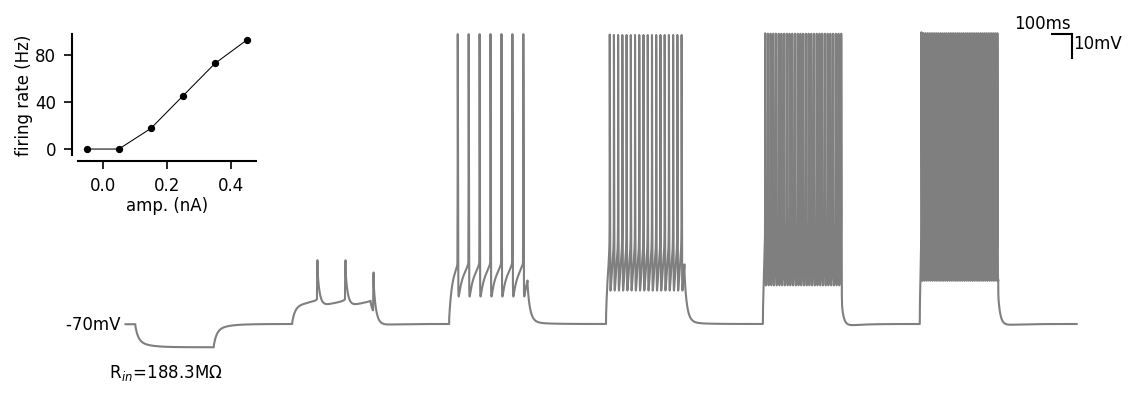

In [7]:
import numpy as np
import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

fig, AX = pt.figure(axes=(len(np.unique(sim.iBranch)), len(np.unique(sim.bgStimFreq))),
                    figsize=(1.5,0.4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

trial = 2

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    c= plt.cm.tab10(iB)
    AX[0][iB].set_title('   branch #%i' % (1+iBranch), fontsize=7, color=c)
    for iF, freq in enumerate(np.unique(sim.bgStimFreq)):
        if iB==0:
            pt.annotate(AX[iF][0], '$\\nu$=%.1eHz ' % freq, (0, 0), ha='right', fontsize=7)
        c= plt.cm.tab10(iB)
        for iS, color, lw in zip([0, 1], [c, 'tab:grey'], [1, 0.5]):
            Vm, dt = sim.Vm[iB, trial, iF, iS] , 0.025
            AX[iF][iB].plot(np.arange(len(Vm))*dt, Vm, color=color, lw=lw)
            AX[iF][iB].axis('off')
pt.set_common_ylims(AX)
pt.set_common_ylims(AX)
pt.draw_bar_scales(AX[0][0], loc='top-right',
                   Xbar=50, Xbar_label='50ms',
                   Ybar=20, Ybar_label='20mV')

In [ ]:
fig, AX = pt.figure(axes=(len(np.unique(sim.iBranch)), 1),
                    figsize=(0.9,1.0))
plt.subplots_adjust(wspace=0.9)

for iB, iBranch in enumerate(np.unique(sim.iBranch)):
    c= plt.cm.tab10(iB)
    AX[iB].set_title('   branch #%i' % (1+iBranch), fontsize=7, color=c)
    for synShuffled, color, lw in zip([0, 1], [c, 'tab:grey'], [1, 0.5]):
        print(sim.output_rate[iB,:,:,synShuffled])
        # print(sim.output_rate[iB,:,:,synShuffled].mean(axis=0))
        pt.plot(np.unique(sim.bgStimFreq), 
                    sim.output_rate[iB,:,:,synShuffled].mean(axis=0),
                    sy=sim.output_rate[iB,:,:,synShuffled].std(axis=0),
                    ax=AX[iB], color=color, ms=1)
    pt.set_plot(AX[iB], xlabel='freq. (Hz)', ylabel='rate (Hz)', xscale='log')
# pt.set_common_ylims(AX)
# pt.set_common_ylims(AX)

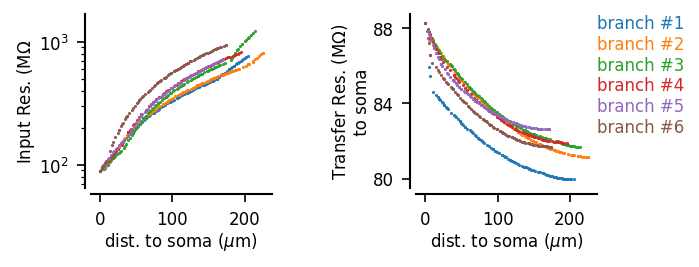

In [5]:
props ={'synShuffleSeed':2,
        'distance': 100,
        'nCluster': 10,
        'subsampling_fraction':10./100.}

fig, AX = pt.figure(figsize=(1.5,2.2), axes=(6, 2), hspace=0, wspace=0.1)
for iBranch in range(6):
    c= plt.cm.tab10(iBranch)
    AX[0][iBranch].set_title('branch #%i' % (1+iBranch), color=c)
    find_clustered_input(cell, iBranch, **props,
            with_plot=True, ax=AX[0][iBranch], syn_color=c)
    find_clustered_input(cell, iBranch, synShuffled=True, **props,
            with_plot=True, syn_color=c, ax=AX[1][iBranch])
    pt.annotate(AX[0][iBranch], 'real', (-0.1,0.1), bold=True, color=c)
    pt.annotate(AX[1][iBranch], 'shuffled', (-0.1,0.1), bold=True, color=c)

In [ ]:
from clustered_input_stim import * 
ID = '864691135396580129_296758' # Basket Cell example
cell = PVcell(ID=ID, debug=False)
index = 0
find_clustered_input(cell, 0, with_plot=True)
find_clustered_input(cell, 0,
        synShuffled=True, with_plot=True)

In [ ]:
import numpy as np
results = np.load('single_sim.npy', allow_pickle=True).item()
t0=200
ISI=200
delay=5
dt=0.025
Vm_soma = results['Vm_soma']
Vm_dend = results['Vm_dend']
real, linear = results['real_dend'], results['linear_dend']

In [ ]:

# real, linear = build_linear_pred(Vm_dend, dt, t0, ISI, delay, len(results['synapses']))
fig, AX = pt.figure(axes=(len(real), 1))
for real, linear, ax in zip(real, linear, AX):
    ax.plot(np.arange(len(real))*dt, real, 'k-', lw=0.5)
    ax.plot(np.arange(len(real))*dt, linear, 'r:')
    ax.set_xlim([0,50])
pt.set_common_ylims(AX)

In [ ]:
import matplotlib.pylab as plt

def build_linear_pred(Vm, dt, t0, ISI, delay):
    t = np.arange(len(Vm))*dt
    # extract single EPSPs
    sEPSPS = []
    for i in range(nCluster):
        tstart = t0+i*ISI
        cond = (t>tstart) & (t<(tstart+ISI))
        sEPSPS.append(Vm[cond]-Vm[cond][0])
    # compute real responses
    tstart = t0+nCluster*ISI
    cond = (t>tstart) & (t<(tstart+ISI))
    real = Vm[cond]
    # then linear pred
    linear = np.ones(np.sum(cond))*real[0]
    t = np.arange(len(real))*dt
    for i, epsp in enumerate(sEPSPS):
        cond = (t>i*delay)
        linear[cond] += epsp[:np.sum(cond)]

    return real, linear

real, linear = build_linear_pred(Vm_dend, dt, t0, ISI, delay)
t = np.arange(len(real))*dt

plt.plot(t, real)
plt.plot(t, linear)
    
    

In [ ]:
sEPSPS = []
for i in range(nCluster):
    tstart = t0+i*ISI
    cond = (t>tstart) & (t<(tstart+ISI))
    sEPSPS.append(Vm_soma[cond])

import matplotlib.pylab as plt
t = np.arange(len(results['Vm_soma']))*results['dt']
tstart = t0+(1+nCluster)*ISI
tstart = t0+nCluster*ISI
cond = (t>(tstart-0*ISI/2.)) & (t<(tstart+ISI))
plt.plot(t[cond], results['Vm_soma'][cond])